In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

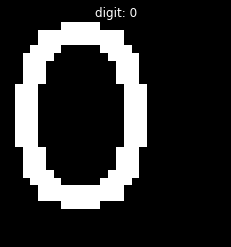

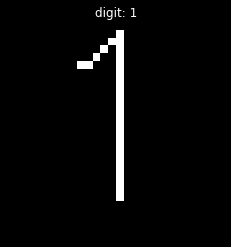

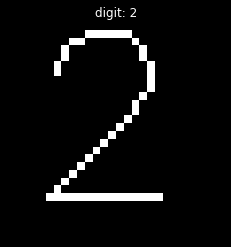

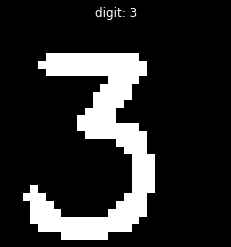

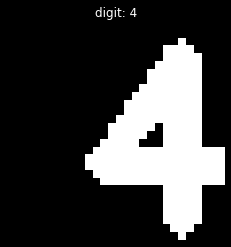

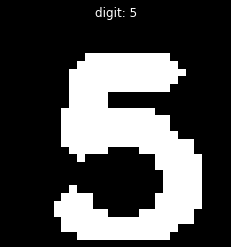

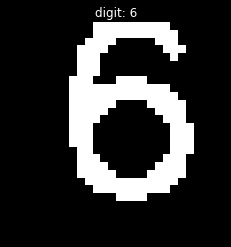

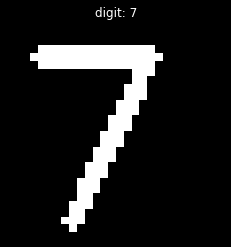

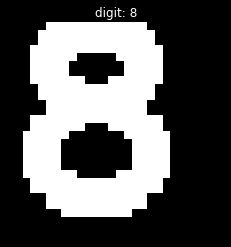

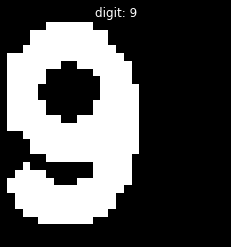

In [2]:
def generate_digit_image(digit):
    text = '%d' % digit
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1
    font_color = 255
    thickness = np.random.randint(1, 4)
    text_size = cv2.getTextSize(text, font, font_size, thickness)[0]
    image = np.zeros((28, 28), dtype = np.uint8)
    loc = (np.random.randint(-3, 11), np.random.randint(21, 28))
    image = cv2.putText(image, text, loc, font, font_size, font_color, thickness)
    return image

for digit in range(10):
    image = generate_digit_image(digit)
    plt.imshow(image, cmap='gray')
    plt.title('digit: %d' % digit)
    plt.axis('off')
    plt.show()

In [3]:
n_digits = 10
n_train_per_class = 1000
n_test_per_class = 100

for digit in range(n_digits):
    print(digit)
    print('generating train')
    for i_sample in range(n_train_per_class):
        image = generate_digit_image(digit)
        cv2.imwrite('DigitClassificationCNN_Dataset/train/Image_%d_%05d.png' % (digit, i_sample), image)
    print('generating test')
    for i_sample in range(n_test_per_class):
        image = generate_digit_image(digit)
        cv2.imwrite('DigitClassificationCNN_Dataset/test/Image_%d_%05d.png' % (digit, i_sample), image)

0
generating train
generating test
1
generating train
generating test
2
generating train
generating test
3
generating train
generating test
4
generating train
generating test
5
generating train
generating test
6
generating train
generating test
7
generating train
generating test
8
generating train
generating test
9
generating train
generating test


In [4]:
class CustomDataset(Dataset):
    def __init__(self, phase):
        self.n_classes = n_digits
        self.root_path = 'DigitClassificationCNN_Dataset/%s' % phase
        if phase == 'train':
            self.n_imgs_per_class = n_train_per_class
        elif phase == 'test':
            self.n_imgs_per_class = n_test_per_class
        
    def __len__(self):
        return self.n_classes*self.n_imgs_per_class

    def __getitem__(self, idx):
        digit = int(idx/self.n_imgs_per_class)
        img_idx = idx-digit*self.n_imgs_per_class
        img_path = self.root_path+'/Image_%d_%05d.png' % (digit, img_idx)
        
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        image = torch.unsqueeze(torch.from_numpy(image), 0).float()/255
        sample = {'image': image, 'label': digit}

        return sample

In [5]:
train_dataset = CustomDataset('train')
test_dataset = CustomDataset('test')
len(train_dataset), len(test_dataset)

(10000, 1000)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=20,  shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20,  shuffle=True)

In [7]:
len(train_loader), len(test_loader)

(500, 50)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5) # n chan in, n chan out, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x.view(-1, 16 * 4 * 4))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion.to(device);

In [11]:
l_loss = []
for epoch in range(10):
    for i, batch in enumerate(train_loader):
        imgs, lbls = batch['image'].to(device), batch['label'].to(device)

        optimizer.zero_grad()

        pred = net(imgs)
        loss = criterion(pred, lbls)
        loss.backward()
        optimizer.step()

        if len(l_loss) == 0:
            l_loss.append(loss.item())
        else:
            l_loss.append(0.5*l_loss[-1]+0.5*loss.item())
    print('epoch', epoch+1, 'loss', loss.item())

epoch 1 loss 2.29648756980896
epoch 2 loss 2.30973482131958
epoch 3 loss 2.2282302379608154
epoch 4 loss 2.0657265186309814
epoch 5 loss 0.9875258207321167
epoch 6 loss 0.9182311296463013
epoch 7 loss 0.12694214284420013
epoch 8 loss 0.25580212473869324
epoch 9 loss 0.21502438187599182
epoch 10 loss 0.06553361564874649


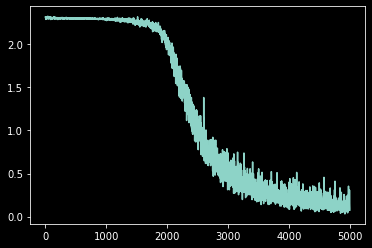

In [12]:
plt.plot(l_loss)
plt.show()

In [13]:
sm = nn.Softmax(dim=1)

correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        imgs, lbls = batch['image'].to(device), batch['label'].to(device)
        pred = sm(net(imgs))
        _, imx = torch.max(pred, 1)
        total += len(lbls)
        correct += (imx == lbls).sum().item()

print('test accuracy', correct / total)

test accuracy 0.966


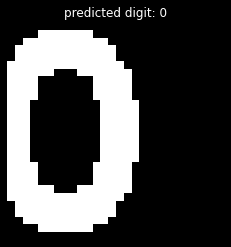

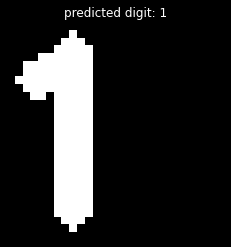

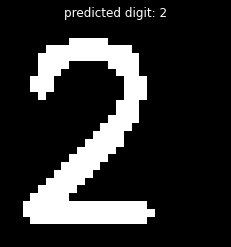

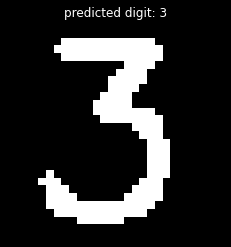

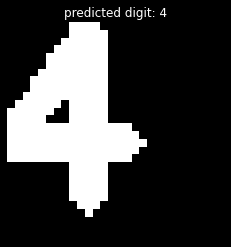

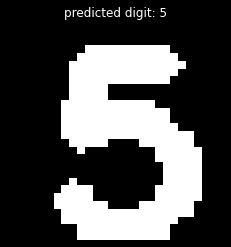

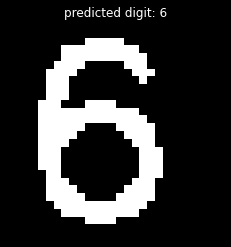

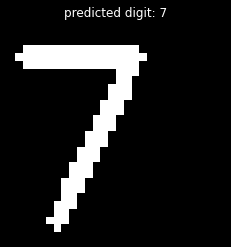

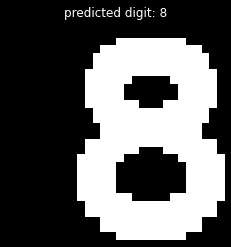

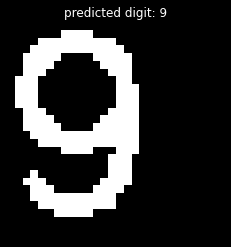

In [14]:
with torch.no_grad():
    for digit in range(10):
        image0 = generate_digit_image(digit)
        image = torch.unsqueeze(torch.from_numpy(image0), 0).float()/255
        pred = sm(net(image))
        _, imx = torch.max(pred, 1)
        pred_idx = imx.item()
        plt.imshow(image0, cmap='gray')
        plt.title('predicted digit: %d' % pred_idx)
        plt.axis('off')
        plt.show()